In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


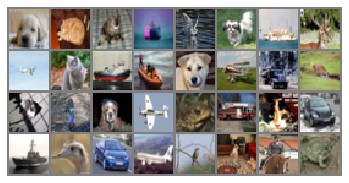

dog   cat   cat   ship  bird  dog   ship  deer  plane cat   ship  ship  dog   plane truck deer  cat   bird  dog   plane frog  truck cat   car   ship  bird  car   plane bird  cat   horse frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [67]:
num_conv = 200

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stack = nn.Sequential(
            nn.Conv2d(3, num_conv, 5),
            nn.BatchNorm2d(num_conv),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),
            nn.Conv2d(num_conv, num_conv, 5),
            nn.BatchNorm2d(num_conv),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),
            nn.Flatten(),
            nn.Linear(num_conv, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Linear(192, 10),
            nn.Softmax(dim=1)
        )
        
    
    def forward(self, x):
        x = self.stack(x)        
        return x
    
net = Net().to(device)
print(net)

Net(
  (stack): Sequential(
    (0): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=200, out_features=384, bias=True)
    (10): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=384, out_features=192, bias=True)
    (13): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=192, out_features=10, bias=True)
    (16): Softmax(dim=1)
  

In [68]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 15, .5)

In [69]:
nep = 100

for epoch in range(nep):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
        scheduler.step()

print('Finished Training')

[1,   500] loss: 0.555
[1,  1000] loss: 0.553
[1,  1500] loss: 0.554
[2,   500] loss: 0.553
[2,  1000] loss: 0.553
[2,  1500] loss: 0.553
[3,   500] loss: 0.553
[3,  1000] loss: 0.553
[3,  1500] loss: 0.553
[4,   500] loss: 0.553
[4,  1000] loss: 0.553


KeyboardInterrupt: 

In [5]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

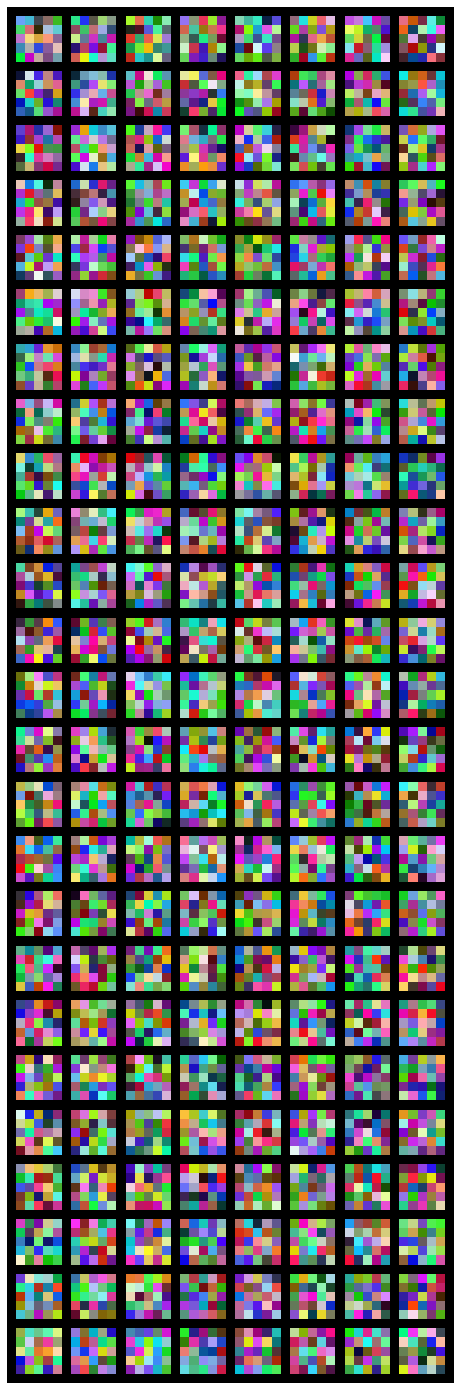

In [70]:
f = net.stack[0].weight.data.clone().cpu()
visTensor(f, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(384, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(trainloader)

In [9]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print('yee')
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
#     # Validation
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in valid_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             del images, labels, outputs
    
#         print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [1/20], Step [1563/1563], Loss: 1.2323
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [2/20], Step [1563/1563], Loss: 1.3193
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [3/20], Step [1563/1563], Loss: 0.8983
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [4/20], Step [1563/1563], Loss: 2.0890
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [5/20], Step [1563/1563], Loss: 0.9078
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [6/20], Step [1563/1563], Loss: 2.3647
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [7/20], Step [1563/1563], Loss: 1.0260
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [8/20], Step [1563/1563], Loss: 1.0222
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
Epoch [9/20], Step [1563/1563], Loss: 0.7182
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee
yee

In [10]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.6 %
Accuracy for class: car   is 81.6 %
Accuracy for class: bird  is 54.9 %
Accuracy for class: cat   is 43.0 %
Accuracy for class: deer  is 58.6 %
Accuracy for class: dog   is 61.1 %
Accuracy for class: frog  is 72.0 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 72.2 %
Accuracy for class: truck is 72.9 %


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


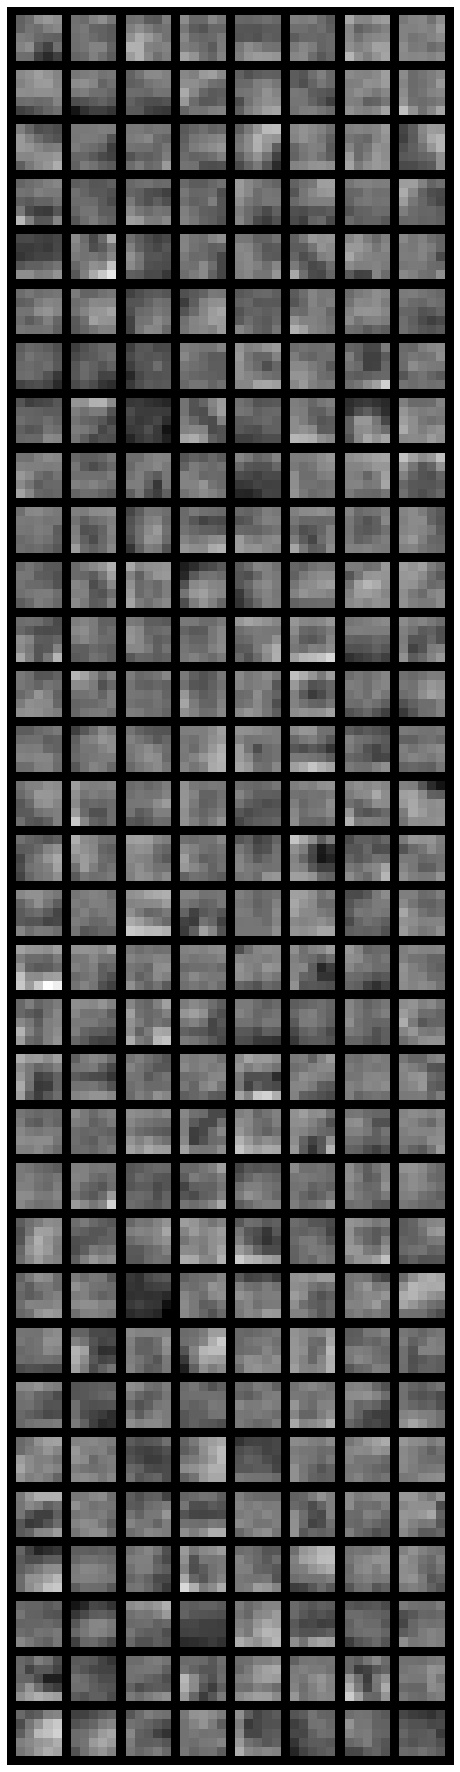

In [14]:
f = model.layer2[0].weight.data.clone().cpu()
visTensor(f, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()